# References

- https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Clustering.ipynb
- https://pycaret.readthedocs.io/en/stable/api/clustering.html

# Install Libraries

In [ ]:
!pip install pycaret
!pip install optuna

# Import Libraries

In [ ]:
from pycaret.clustering import *
import pandas as pd
import optuna
from tqdm import tqdm

# Data Understanding

# Load Data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Algoritma-dan-Pemrograman-ITS/modul-pkt/main/Materi%203%20Clustering/datasets/jewelry_customer.csv")
data.head()

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130


# Modeling

## Setup Environment and Pipeline

In [ ]:
from pycaret.clustering import *
s = setup(
    data,
    # normalize = True,
    # remove_multicollinearity = True,
    # transformation = True,
    # pca = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(505, 4)"
2,Transformed data shape,"(505, 4)"
3,Numeric features,4
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [ ]:
from pycaret.clustering import ClusteringExperiment
exp = ClusteringExperiment()

In [ ]:
type(exp)

pycaret.clustering.oop.ClusteringExperiment

In [ ]:
exp.setup(
    data,
    # normalize = True,
    # remove_multicollinearity = True,
    # transformation = True,
    # pca = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(505, 4)"
2,Transformed data shape,"(505, 4)"
3,Numeric features,4
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


## Create Model

In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch


In [ ]:
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7207,5011.8115,0.4114,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Assign Model

In [ ]:
kmeans_cluster = assign_model(kmeans)
kmeans_cluster

,Age,Income,SpendingScore,Savings,Cluster
0,58,77769,0.791329,6559.830078,Cluster 2
1,59,81799,0.791082,5417.661621,Cluster 2
2,62,74751,0.702657,9258.993164,Cluster 2
3,59,74373,0.765680,7346.334473,Cluster 2
4,87,17760,0.348778,16869.507812,Cluster 1
...,...,...,...,...,...
500,28,101206,0.387441,14936.775391,Cluster 3
501,93,19934,0.203140,17969.693359,Cluster 1
502,90,35297,0.355149,16091.402344,Cluster 1
503,91,20681,0.354679,18401.087891,Cluster 1


## Analyze Model


In [ ]:
# Plot pca cluster plot
plot_model(kmeans, plot = 'cluster')

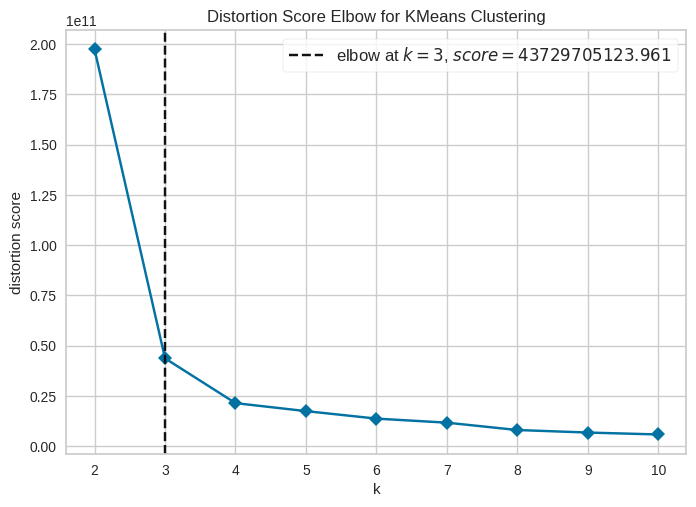

In [ ]:
# Plot elbow
plot_model(kmeans, plot = 'elbow')

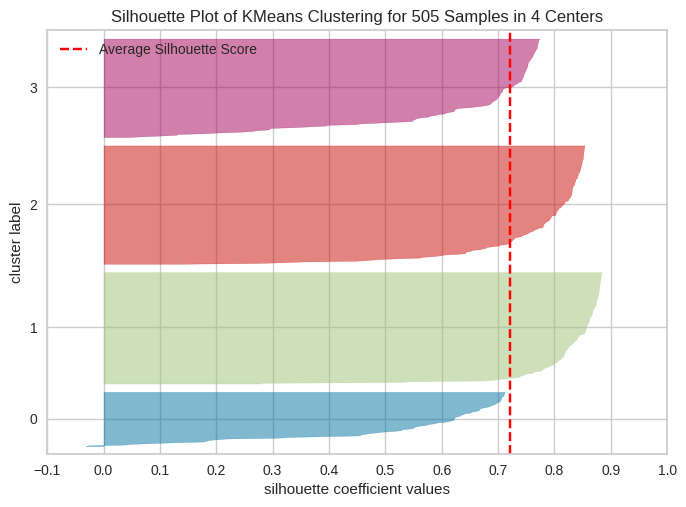

In [ ]:
# Plot silhouette
plot_model(kmeans, plot = 'silhouette')

In [ ]:
evaluate_model(kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Save Model

In [ ]:
# Save pipeline
save_model(kmeans, 'kmeans_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Age', 'Income', 'SpendingScore',
                                              'Savings'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model', KMeans(n_clusters=4, random_state=123))]),
 'kmeans_pipeline.pkl')

In [ ]:
# Load pipeline
kmeans_pipeline = load_model('kmeans_pipeline')
kmeans_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Age', 'Income', 'SpendingScore',
                                             'Savings'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model', KMeans(n_clusters=4, random_state=123))])

# Parameter Tuning

## Define Parameter Grid

In [ ]:
def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        'normalize': trial.suggest_categorical('normalize', [True, False]),
        'normalize_method': trial.suggest_categorical('normalize_method', ['zscore', 'minmax', 'maxabs', 'robust']),
        'remove_multicollinearity': trial.suggest_categorical('remove_multicollinearity', [True, False]),
        'transformation': trial.suggest_categorical('transformation', [True, False]),
        'pca': trial.suggest_categorical('pca', [True, False]),
        'pca_method': trial.suggest_categorical('pca_method', ['linear', 'kernel', 'incremental']),
        'model': trial.suggest_categorical('model', ['kmeans'])
    }

    # Create a new setup with current parameters
    exp = ClusteringExperiment()
    try:
        exp.setup(data,
                  normalize=params['normalize'],
                  normalize_method=params['normalize_method'],
                  remove_multicollinearity=params['remove_multicollinearity'],
                  transformation=params['transformation'],
                  pca=params['pca'],
                  pca_method=params['pca_method'],
                  session_id=123,
                  verbose=False)

        # Create and evaluate the specified clustering model
        model = exp.create_model(params['model'], verbose=False)
        score = exp.pull()['Silhouette'].values[0]

        return score
    except Exception as e:
        # Return a very low score for invalid combinations
        return -1000

In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-09-03 02:23:40,240] A new study created in memory with name: no-name-13748ec2-5ba0-414f-83ba-8dad83c4f398


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-09-03 02:23:40,934] Trial 0 finished with value: 0.7809 and parameters: {'normalize': False, 'normalize_method': 'robust', 'remove_multicollinearity': True, 'transformation': True, 'pca': True, 'pca_method': 'incremental', 'model': 'kmeans'}. Best is trial 0 with value: 0.7809.
[I 2024-09-03 02:23:41,975] Trial 1 finished with value: 0.7809 and parameters: {'normalize': False, 'normalize_method': 'minmax', 'remove_multicollinearity': False, 'transformation': True, 'pca': True, 'pca_method': 'linear', 'model': 'kmeans'}. Best is trial 0 with value: 0.7809.
[I 2024-09-03 02:23:43,133] Trial 2 finished with value: 0.7274 and parameters: {'normalize': True, 'normalize_method': 'minmax', 'remove_multicollinearity': True, 'transformation': False, 'pca': False, 'pca_method': 'incremental', 'model': 'kmeans'}. Best is trial 0 with value: 0.7809.
[I 2024-09-03 02:23:44,280] Trial 3 finished with value: 0.7336 and parameters: {'normalize': True, 'normalize_method': 'maxabs', 'remove_mult

In [ ]:
# Get the best parameters
best_params = study.best_params
best_score = study.best_value

print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param} = {value}")
print(f"Best Silhouette Score: {best_score}")


Best Parameters:
normalize = False
normalize_method = robust
remove_multicollinearity = True
transformation = True
pca = True
pca_method = incremental
model = kmeans
Best Silhouette Score: 0.7809


In [ ]:
# Optuna visualization
print("\nOptuna Study Visualizations:")
try:
    from optuna.visualization import plot_param_importances, plot_optimization_history
    import matplotlib.pyplot as plt

    # Plot parameter importances
    fig = plot_param_importances(study)
    fig.show()

    # Plot optimization history
    fig = plot_optimization_history(study)
    fig.show()

except ImportError:
    print("Optuna visualization requires matplotlib. Please install it to see the plots.")


Optuna Study Visualizations:


## Use the Best Model

In [ ]:
# Set up the environment with the best parameters
exp = ClusteringExperiment()
exp.setup(data,
          normalize=best_params['normalize'],
          normalize_method=best_params['normalize_method'],
          remove_multicollinearity=best_params['remove_multicollinearity'],
          transformation=best_params['transformation'],
          pca=best_params['pca'],
          pca_method=best_params['pca_method'],
          session_id=123)

# Create the best model
best_model = exp.create_model(best_params['model'])

,Description,Value
0,Session id,123
1,Original data shape,"(505, 4)"
2,Transformed data shape,"(505, 4)"
3,Numeric features,4
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Remove multicollinearity,True
9,Multicollinearity threshold,0.900000


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7809,3519.5778,0.3135,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

## Assign the Best Model

In [ ]:
best_model_cluster = assign_model(best_model)
best_model_cluster

,Age,Income,SpendingScore,Savings,Cluster
0,58,77769,0.791329,6559.830078,Cluster 2
1,59,81799,0.791082,5417.661621,Cluster 2
2,62,74751,0.702657,9258.993164,Cluster 2
3,59,74373,0.765680,7346.334473,Cluster 2
4,87,17760,0.348778,16869.507812,Cluster 1
...,...,...,...,...,...
500,28,101206,0.387441,14936.775391,Cluster 0
501,93,19934,0.203140,17969.693359,Cluster 1
502,90,35297,0.355149,16091.402344,Cluster 1
503,91,20681,0.354679,18401.087891,Cluster 1


## Analyze the Best Model


In [ ]:
# Plot pca cluster plot
plot_model(best_model, plot = 'cluster')

In [ ]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Save the Best Model

In [ ]:
# Save pipeline
save_model(best_model, 'best_model_tuning_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Age', 'Income', 'SpendingScore',
                                              'Savings'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model', KMeans(n_clusters=4, random_state=123))]),
 'best_model_tuning_pipeline.pkl')

In [ ]:
# Load pipeline
best_model_tuning_pipeline = load_model('best_model_tuning_pipeline')
best_model_tuning_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Age', 'Income', 'SpendingScore',
                                             'Savings'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model', KMeans(n_clusters=4, random_state=123))])